<a href="https://colab.research.google.com/github/Sidharth-Saji/WildFiire_Monitoring_Using_Satellite_Image/blob/main/WildFire_Detection_Using_Satellite_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Libraries

In [1]:
import numpy as np
import pandas as pd
import os.path
import tensorflow as tf
from pathlib import Path

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A
import cv2 as cv

from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')





Mounted at /content/drive


##Creatign Dataframes

In [2]:
def create_df_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures"""

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [3]:
train_dir = Path('/content/drive/MyDrive/ML DATASETS/train')
filepaths = list(train_dir.glob(r'**/*.jpg'))

val_dir=Path('/content/drive/MyDrive/ML DATASETS/valid')
filepaths_valid = list(val_dir.glob(r'**/*.jpg'))


In [4]:
df_train = create_df_img(filepaths)
df_valid=create_df_img(filepaths_valid)

df_train.head()
df_valid.head()

,Filepath,Label
0,/content/drive/MyDrive/ML DATASETS/valid/nowil...,nowildfire
1,/content/drive/MyDrive/ML DATASETS/valid/wildf...,wildfire
2,/content/drive/MyDrive/ML DATASETS/valid/nowil...,nowildfire
3,/content/drive/MyDrive/ML DATASETS/valid/wildf...,wildfire
4,/content/drive/MyDrive/ML DATASETS/valid/wildf...,wildfire


#READING THE DATASET 

In [5]:
def print_df(df):

    print(f'Number of pictures: {df.shape[0]}\n')
    print(f'Number of different labels: {len(df.Label.unique())}\n')
    print(f'Labels: {df.Label.unique()}')  
def printhead(df):
    print(df.head(5))

In [6]:
printhead(df_train)
print_df(df_train)

printhead(df_valid)
print_df(df_valid)

                                            Filepath       Label
0  /content/drive/MyDrive/ML DATASETS/train/wildf...    wildfire
1  /content/drive/MyDrive/ML DATASETS/train/wildf...    wildfire
2  /content/drive/MyDrive/ML DATASETS/train/nowil...  nowildfire
3  /content/drive/MyDrive/ML DATASETS/train/nowil...  nowildfire
4  /content/drive/MyDrive/ML DATASETS/train/wildf...    wildfire
Number of pictures: 30264

Number of different labels: 2

Labels: ['wildfire' 'nowildfire']
                                            Filepath       Label
0  /content/drive/MyDrive/ML DATASETS/valid/nowil...  nowildfire
1  /content/drive/MyDrive/ML DATASETS/valid/wildf...    wildfire
2  /content/drive/MyDrive/ML DATASETS/valid/nowil...  nowildfire
3  /content/drive/MyDrive/ML DATASETS/valid/wildf...    wildfire
4  /content/drive/MyDrive/ML DATASETS/valid/wildf...    wildfire
Number of pictures: 6320

Number of different labels: 2

Labels: ['nowildfire' 'wildfire']


#DATA AUGMENTATION 

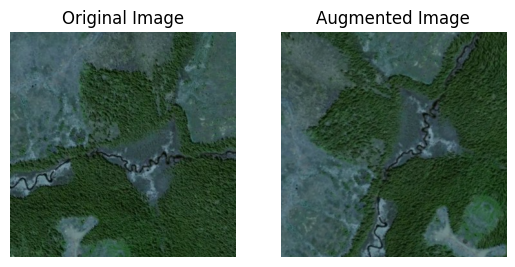

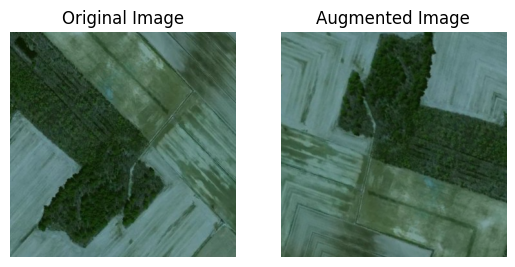

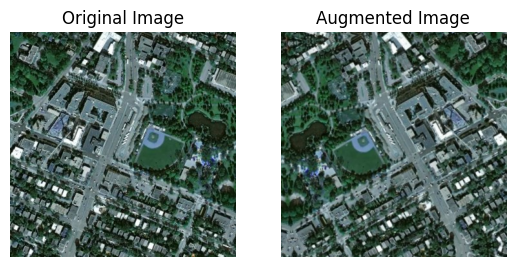

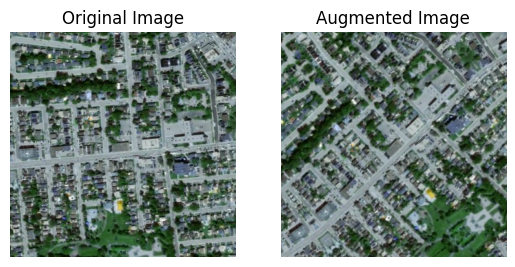

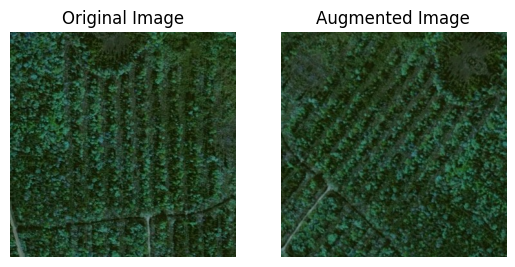

In [7]:
def augmentation_image(image):
    aug = A.Compose([
        A.Flip(),
        A.Rotate(limit=75,always_apply=True),
    ])
    augmented_image = aug(image=image)['image']
    return augmented_image

def display_original_augment_image(df):
    random_data = df.sample(n=5)
    for i in range(len(random_data)):
        image = cv.imread(random_data.iloc[i].Filepath)
        augmented_image = augmentation_image(image)

        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Original Image")

        plt.subplot(1,2,2)
        plt.imshow(augmented_image)
        plt.title("Augmented Image")
        plt.axis('off')
        plt.show()

display_original_augment_image(df_train)

In [8]:
BATCH_SIZE = 256

train_datagenerator = ImageDataGenerator(dtype='float32', rescale= 1./255., preprocessing_function=augmentation_image)
train_generator = train_datagenerator.flow_from_dataframe(df_train,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=True,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (350,350),
                                                    class_mode = 'categorical')

val_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
val_generator = val_datagen.flow_from_dataframe(df_valid,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=True,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (350,350),
                                                    class_mode = 'categorical')

Found 30264 validated image filenames belonging to 2 classes.
Found 6320 validated image filenames belonging to 2 classes.


# MODEL BUILDING

In [9]:
import tensorflow as tf
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [10]:
shrink = 1e-3
image_shape=plt.imread(df_train["Filepath"][0]).shape
model = Sequential([
    Conv2D(filters = 8 , kernel_size = 2, activation = 'relu', 
    input_shape = image_shape), MaxPooling2D(pool_size = 2),
    
    Conv2D(filters = 16 , kernel_size = 2, activation = 'relu', 
    input_shape = image_shape), MaxPooling2D(pool_size = 2),
    
    Conv2D(filters = 32 , kernel_size = 2, activation = 'relu',
           kernel_regularizer = regularizers.l2(shrink)),
    MaxPooling2D(pool_size = 2),
    
    
    Flatten(),
    Dense(300,activation='relu'),
    Dropout(0.5),
    Dense(100,activation='relu'),
    Dropout(0.4),
    Dense(2,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 349, 349, 8)       104       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 174, 174, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 173, 173, 16)      528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 86, 86, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 85, 85, 32)        2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 42, 42, 32)       0

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

checkpointer = ModelCheckpoint('model.hdf5',verbose=1, save_best_only= True)

early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)

optimizer = optimizers.Adam(learning_rate= 0.00001, weight_decay= 1e-5)

checkpointer = ModelCheckpoint('model.hdf5',verbose=1, save_best_only= True)

early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)

optimizer = optimizers.Adam(learning_rate= 0.00001, weight_decay= 1e-5)

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam',
                    metrics=['AUC','acc'])


history = model.fit(train_generator,
                    epochs = 40,
                    verbose = 1,
                    validation_data = val_generator,
                    callbacks = [checkpointer, early_stopping])

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam',
                    metrics=['AUC','acc'])


history = model.fit(train_generator,
                    epochs = 40,
                    verbose = 1,
                    validation_data = val_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/40
  2/119 [..............................] - ETA: 2:02:34 - loss: 1.8739 - auc: 0.4826 - acc: 0.4570